# Quantum NLP Challenge

In [1]:
%pdb 0

Automatic pdb calling has been turned OFF


In [2]:
%matpotlib inline

UsageError: Line magic function `%matpotlib` not found.


In [3]:
import sys

In [4]:
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scikit-learn

## Data

In [5]:
import pandas as pd
import numpy as np
import sklearn as sk

RANDOM_SEED = 220811
np.random.seed(RANDOM_SEED)

In [6]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [7]:
from lambeq import BobcatParser, DepCCGParser
from discopy import grammar

In [8]:
from lambeq import Rewriter
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

In [9]:
from pytket.circuit.display import render_circuit_jupyter

In [10]:
from pytket.extensions.qiskit import AerBackend

In [11]:
from discopy.tensor import Diagram

In [12]:
df = pd.read_csv("MC1.TXT", header=None, sep=", ", engine="python")

In [13]:
df.columns = ["s1", "s2", "label"]

In [14]:
df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


In [15]:
vocab = set()
lengths = set()

for i, r in df.iterrows():
    tokens = r.s1.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]
    tokens = r.s2.split(" ")
    lengths.add(len(tokens))
    [vocab.add(w) for w in tokens]

In [16]:
print(vocab, len(vocab), max(lengths))

{'creates', 'cook', 'code', 'hacker', 'writes', 'tasty', 'prepares', 'devoted', 'experienced', 'chef', 'advanced', 'programmer', 'skilful', 'complicated', 'meal', 'dish'} 16 5


## Lambeq tutorial

### Sentence input

In [17]:
sentence = "John cooks delicious food"

In [18]:
parser = BobcatParser()

In [19]:
diagram = parser.sentence2diagram(sentence)

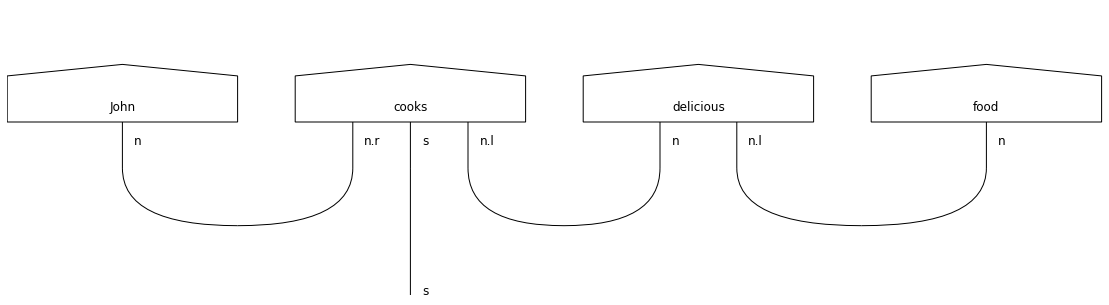

In [20]:
grammar.draw(diagram, figsize=(16, 4), fontsize=12)

### Diagram rewriting

In [21]:
# Prepositional phrase rewrite rule
rewriter = Rewriter(["prepositional_phrase", "determiner"])
rewritten_diagram = rewriter(diagram)

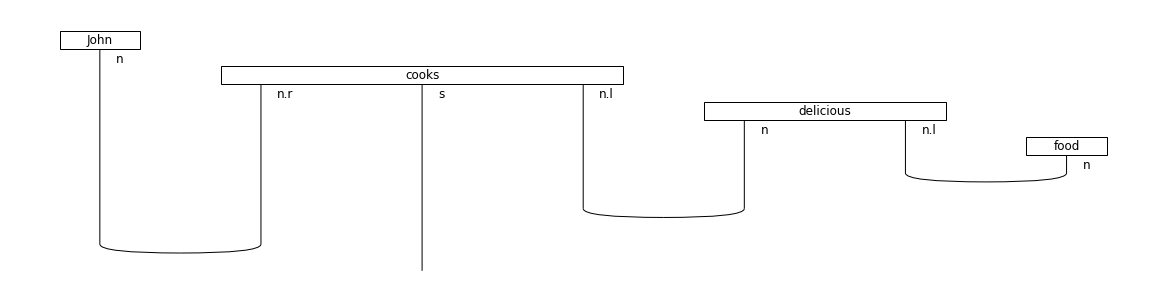

In [22]:
rewritten_diagram.draw(figsize=(16, 4), fontsize=12)

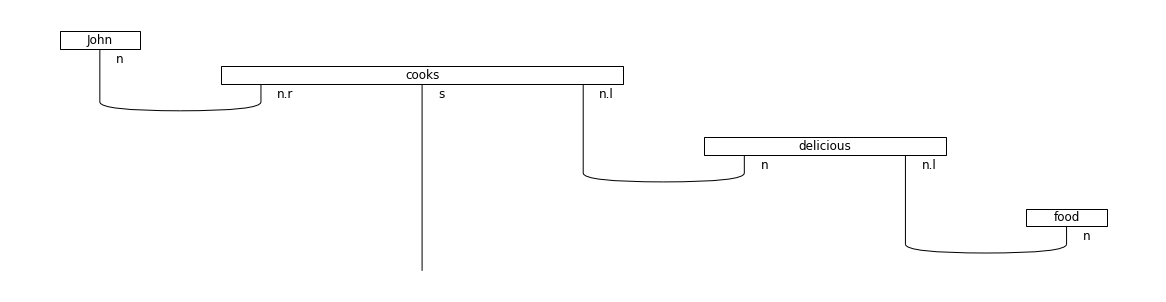

In [23]:
# Normalize
normalized_diagram = rewritten_diagram.normal_form()
normalized_diagram.draw(figsize=(16, 4), fontsize=12)

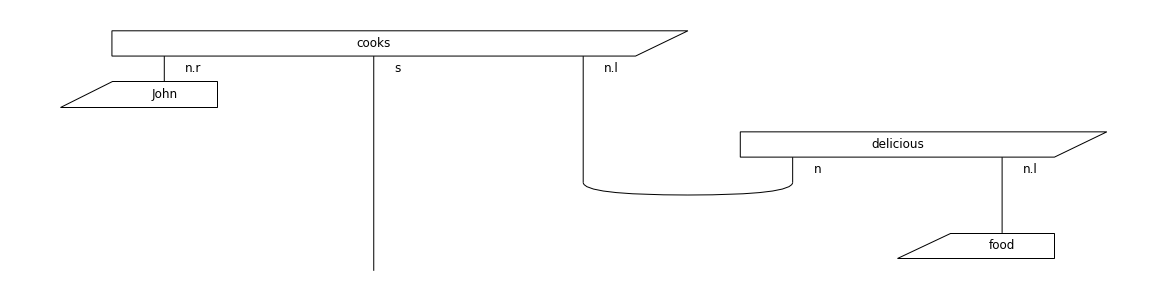

In [24]:
# Remove cups
decupped_diagram = remove_cups(normalized_diagram)
decupped_diagram.draw(figsize=(16, 4), fontsize=12)

### Parametrization

In [25]:
# Atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

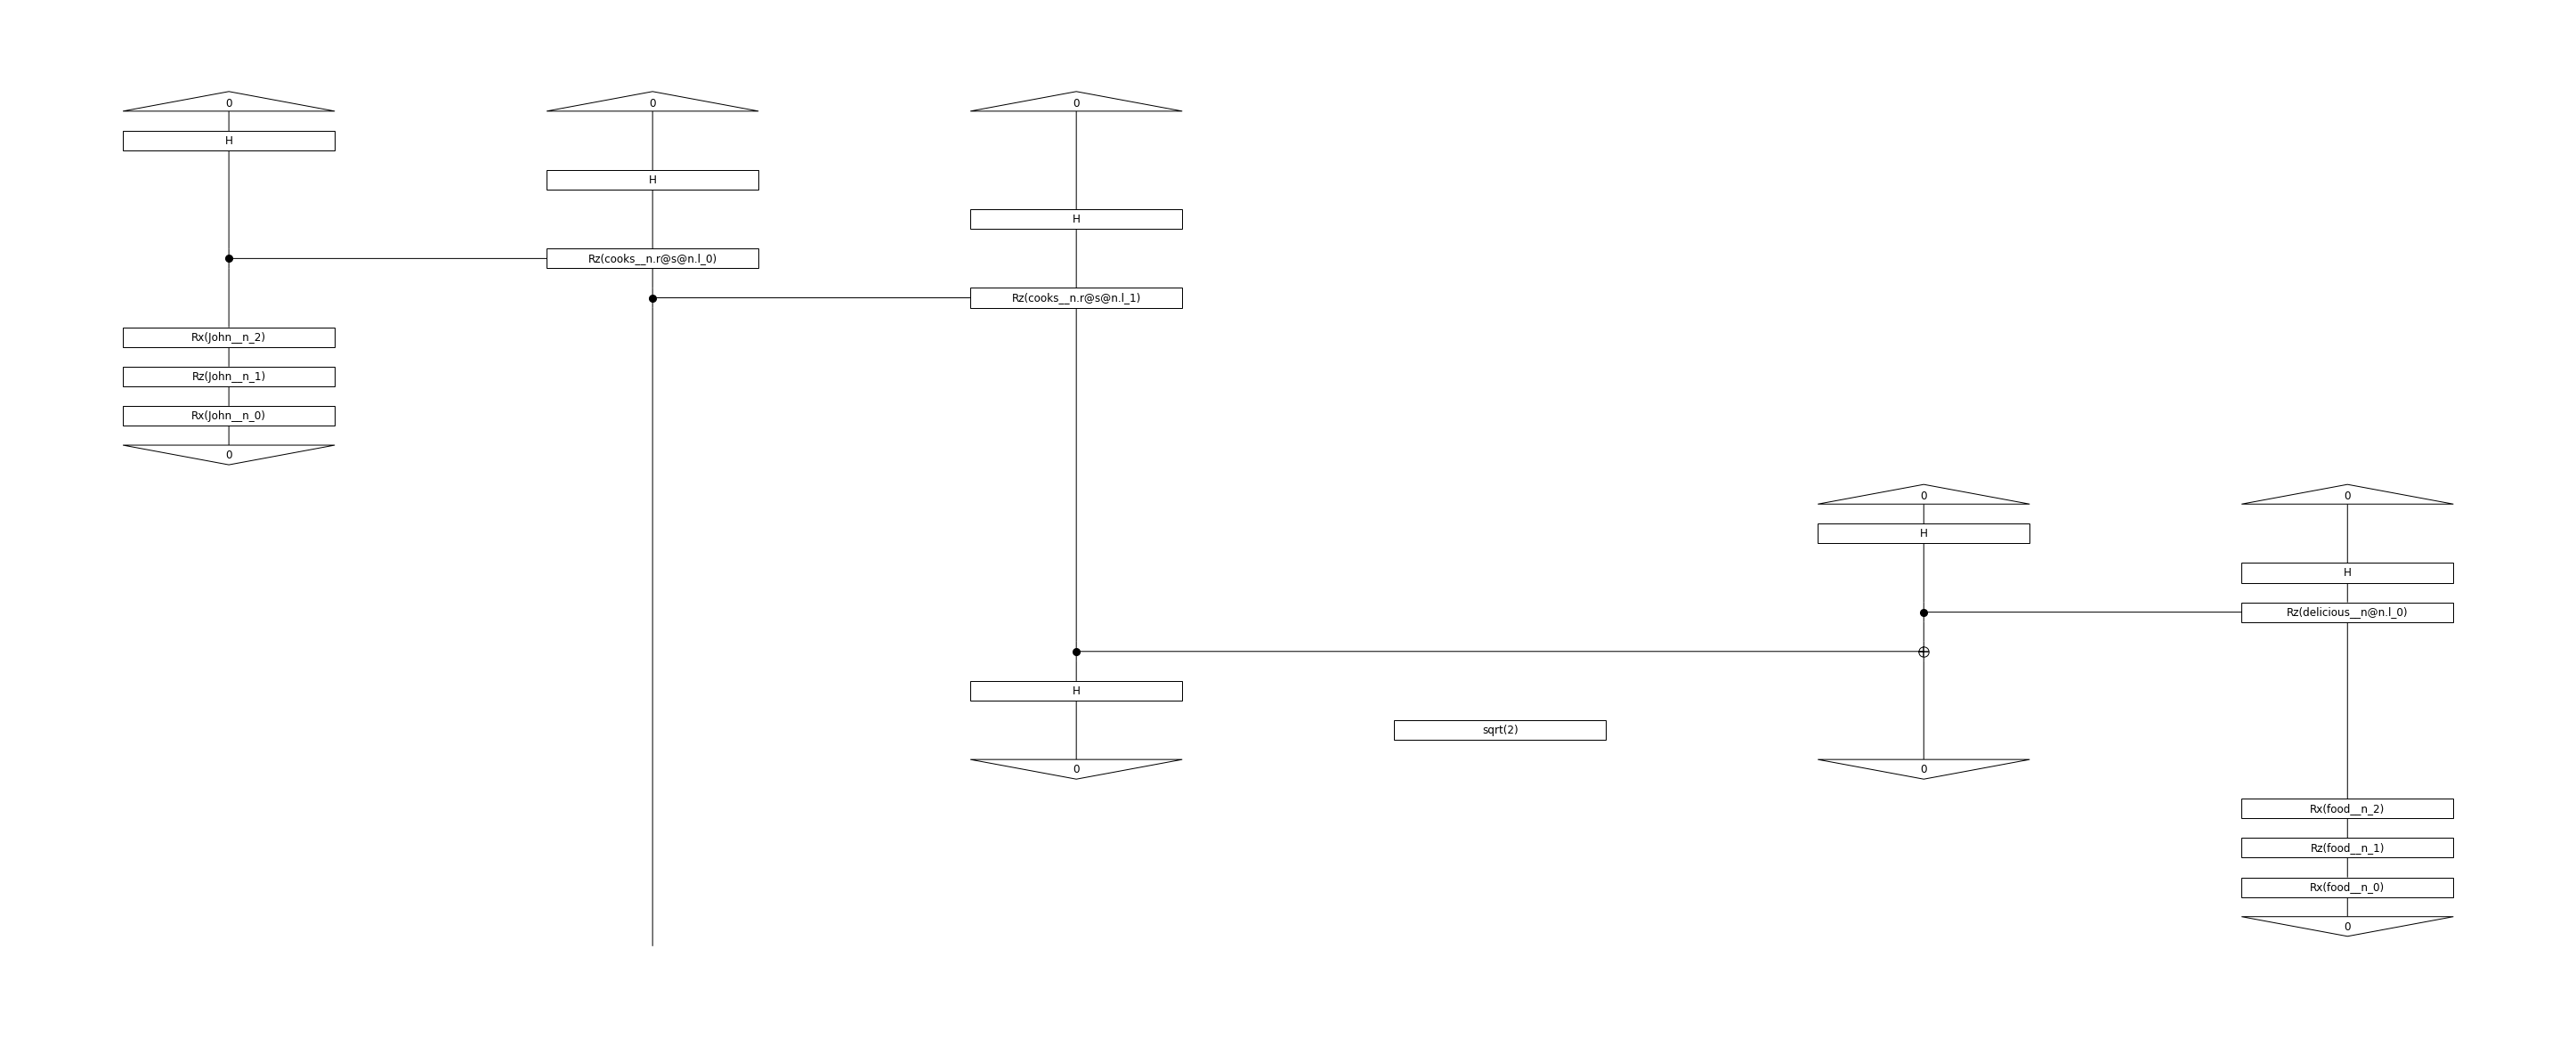

In [26]:
# Convert string diagram to qc - 1 qubit per atomic type
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers=1)
discopy_circuit = ansatz(decupped_diagram)
discopy_circuit.draw(figsize=(40, 16), fontsize=12)

In [27]:
# Convert qc from DisCoPy to pytket format
tket_circuit = discopy_circuit.to_tk()
render_circuit_jupyter(tket_circuit)

### DisCoPy's IQPansatz Deep-Dive

In [28]:
from discopy.quantum.circuit import IQPansatz as IQP

In [29]:
pprint = lambda c: print(str(c).replace(' >>', '\n  >>'))
pprint(IQP(2, [[0.1], [0.3]]))

H @ Id(1)
  >> Id(1) @ H
  >> CRz(0.1)
  >> H @ Id(1)
  >> Id(1) @ H
  >> CRz(0.3)


In [30]:
from discopy.quantum.circuit import Circuit, Id
from discopy.quantum.gates import CX, Controlled, X
from discopy.tensor import Tensor
from math import pi

class Customansatz(Circuit):
    """
    Builds an IQP ansatz on n qubits, if n = 1 returns an Euler decomposition

    >>> pprint = lambda c: print(str(c).replace(' >>', '\\n  >>'))
    >>> pprint(IQPansatz(3, [[0.1, 0.2], [0.3, 0.4]]))
    H @ Id(2)
      >> Id(1) @ H @ Id(1)
      >> Id(2) @ H
      >> CRz(0.1) @ Id(1)
      >> Id(1) @ CRz(0.2)
      >> H @ Id(2)
      >> Id(1) @ H @ Id(1)
      >> Id(2) @ H
      >> CRz(0.3) @ Id(1)
      >> Id(1) @ CRz(0.4)
    >>> print(IQPansatz(1, [0.3, 0.8, 0.4]))
    Rx(0.3) >> Rz(0.8) >> Rx(0.4)
    """
    def __init__(self, n_qubits, params):
        from discopy.quantum.gates import H, Rx, Rz, CRz

        def layer(thetas):
            # hadamards = Id(0).tensor(*(n_qubits * [H]))
            eulers = Rz(thetas[0][0]) >> Rx(pi/2) >> Rz(thetas[0][1]) >> Rx(-pi/2) >> Rz(thetas[0][2])
            for i in range(1, len(thetas)):
                eulers = eulers @ (Rz(thetas[i][0]) >> Rx(pi/2) >> Rz(thetas[i][1]) >> Rx(-pi/2) >> Rz(thetas[i][2]))
            eulers = Id(n_qubits) >> eulers
            cxs = Id(n_qubits).then(*(
                Id(i) @ CX @ Id(n_qubits - 2 - i)
                for i in range(n_qubits - 1)))
            # cxs = cxs >> CX(0, n_qubits - 1)
            return eulers >> cxs >> Controlled(X, distance=-(n_qubits - 1))
        if n_qubits == 1:
            circuit = Rx(params[0]) >> Rz(params[1]) >> Rx(params[2])
        else:
            depth = Tensor.np.shape(params)[0]
            circuit = Id(n_qubits).then(*(
                layer(params[i]) for i in range(depth)))
        super().__init__(
            circuit.dom, circuit.cod, circuit.boxes, circuit.offsets)

In [31]:
params = [[[0.1, 0.2, 0.3], [0.3, 0.4, 0.5], [0.5, 0.6, 0.7]],
          [[0.2, 0.2, 0.3], [0.3, 0.3, 0.5], [0.6, 0.6, 0.7]]]

In [32]:
Tensor.np.shape(params)

(2, 3, 3)

In [33]:
params[0]

[[0.1, 0.2, 0.3], [0.3, 0.4, 0.5], [0.5, 0.6, 0.7]]

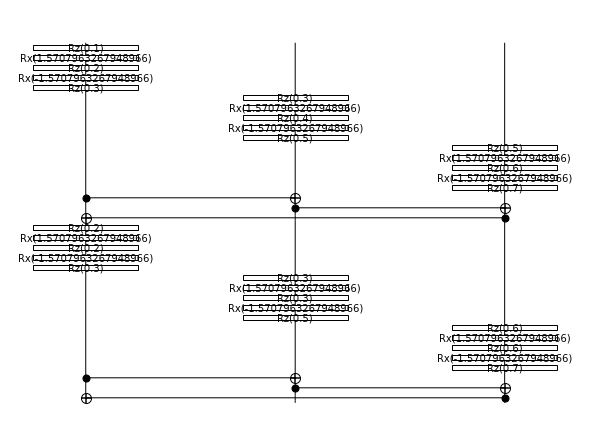

In [34]:
circuit = Customansatz(3, params)
circuit.draw(figsize=(8, 6))

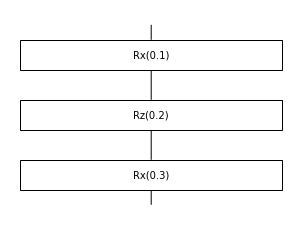

In [35]:
circuit2 = Customansatz(1, [0.1, 0.2, 0.3])
circuit2.draw(figsize=(4, 3))

### Lambeq's IQPAnsatz Deep-Dive

In [36]:
from collections.abc import Mapping
from lambeq import CircuitAnsatz
from typing import Any, Callable, Optional

from discopy.quantum.circuit import (Circuit, Discard, Functor, Id,
                                     IQPansatz as IQP, qubit)
from discopy.quantum.gates import Bra, Ket, Rx, Rz
from discopy.rigid import Box, Diagram, Ty

from lambeq.ansatz import Symbol
from lambeq.ansatz.circuit import _ArMapT


class CustomIQPAnsatz(CircuitAnsatz):
    """Instantaneous Quantum Polynomial ansatz.

    An IQP ansatz interleaves layers of Hadamard gates with diagonal
    unitaries. This class uses :py:obj:`n_layers-1` adjacent CRz gates
    to implement each diagonal unitary.

    """

    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 n_single_qubit_params: int = 3,
                 discard: bool = False,
                 special_cases: Optional[Callable[[_ArMapT], _ArMapT]] = None):
        """Instantiate an IQP ansatz.

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`discopy.rigid.Ty` to the number of
            qubits it uses in a circuit.
        n_layers : int
            The number of IQP layers used by the ansatz.
        n_single_qubit_params : int, default: 3
            The number of single qubit rotations used by the ansatz.
        discard : bool, default: False
            Discard open wires instead of post-selecting.
        special_cases : callable, optional
            A function that transforms an arrow map into one specifying
            special cases that should not be converted by the Ansatz
            class.

        """
        super().__init__(ob_map=ob_map, n_layers=n_layers,
                         n_single_qubit_params=n_single_qubit_params)

        if special_cases is None:
            special_cases = self._special_cases

        self.n_layers = n_layers
        self.n_single_qubit_params = n_single_qubit_params
        self.discard = discard
        self.functor = Functor(ob=self.ob_map,
                               ar=special_cases(self._ar))

    def _ar(self, box: Box) -> Circuit:
        label = self._summarise_box(box)
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        n_1qubit_params = self.n_single_qubit_params
        
        # print("box", box, label)
        # print("n_qubits", n_qubits)
        # print("n_layers", n_layers)
        # print("n_1qubit_params", n_1qubit_params)

        if n_qubits == 0:
            circuit = Id()
        elif n_qubits == 1:
            syms = [Symbol(f'{label}_{i}') for i in range(n_1qubit_params)]
            rots = [Rx, Rz]
            circuit = Id(qubit)
            for i, sym in enumerate(syms):
                circuit >>= rots[i % 2](sym)
        else:
            # We have three rotations for each qubit corresponding to
            # the Euler decomposition
            n_params = n_layers * n_qubits * 3
            # print("n_params", n_params)
            syms = [Symbol(f'{label}_{i}') for i in range(n_params)]
            # print("syms", syms)
            params: np.ndarray[Any, np.dtype[Any]] = np.array(syms).reshape(
                    (n_layers, n_qubits, 3))
            # print("params")
            # print(params)
            circuit = Customansatz(n_qubits, params)

        if cod > dom:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        elif self.discard:
            circuit >>= Id(cod) @ Discard(dom - cod)
        else:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        return circuit


In [37]:
# Atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

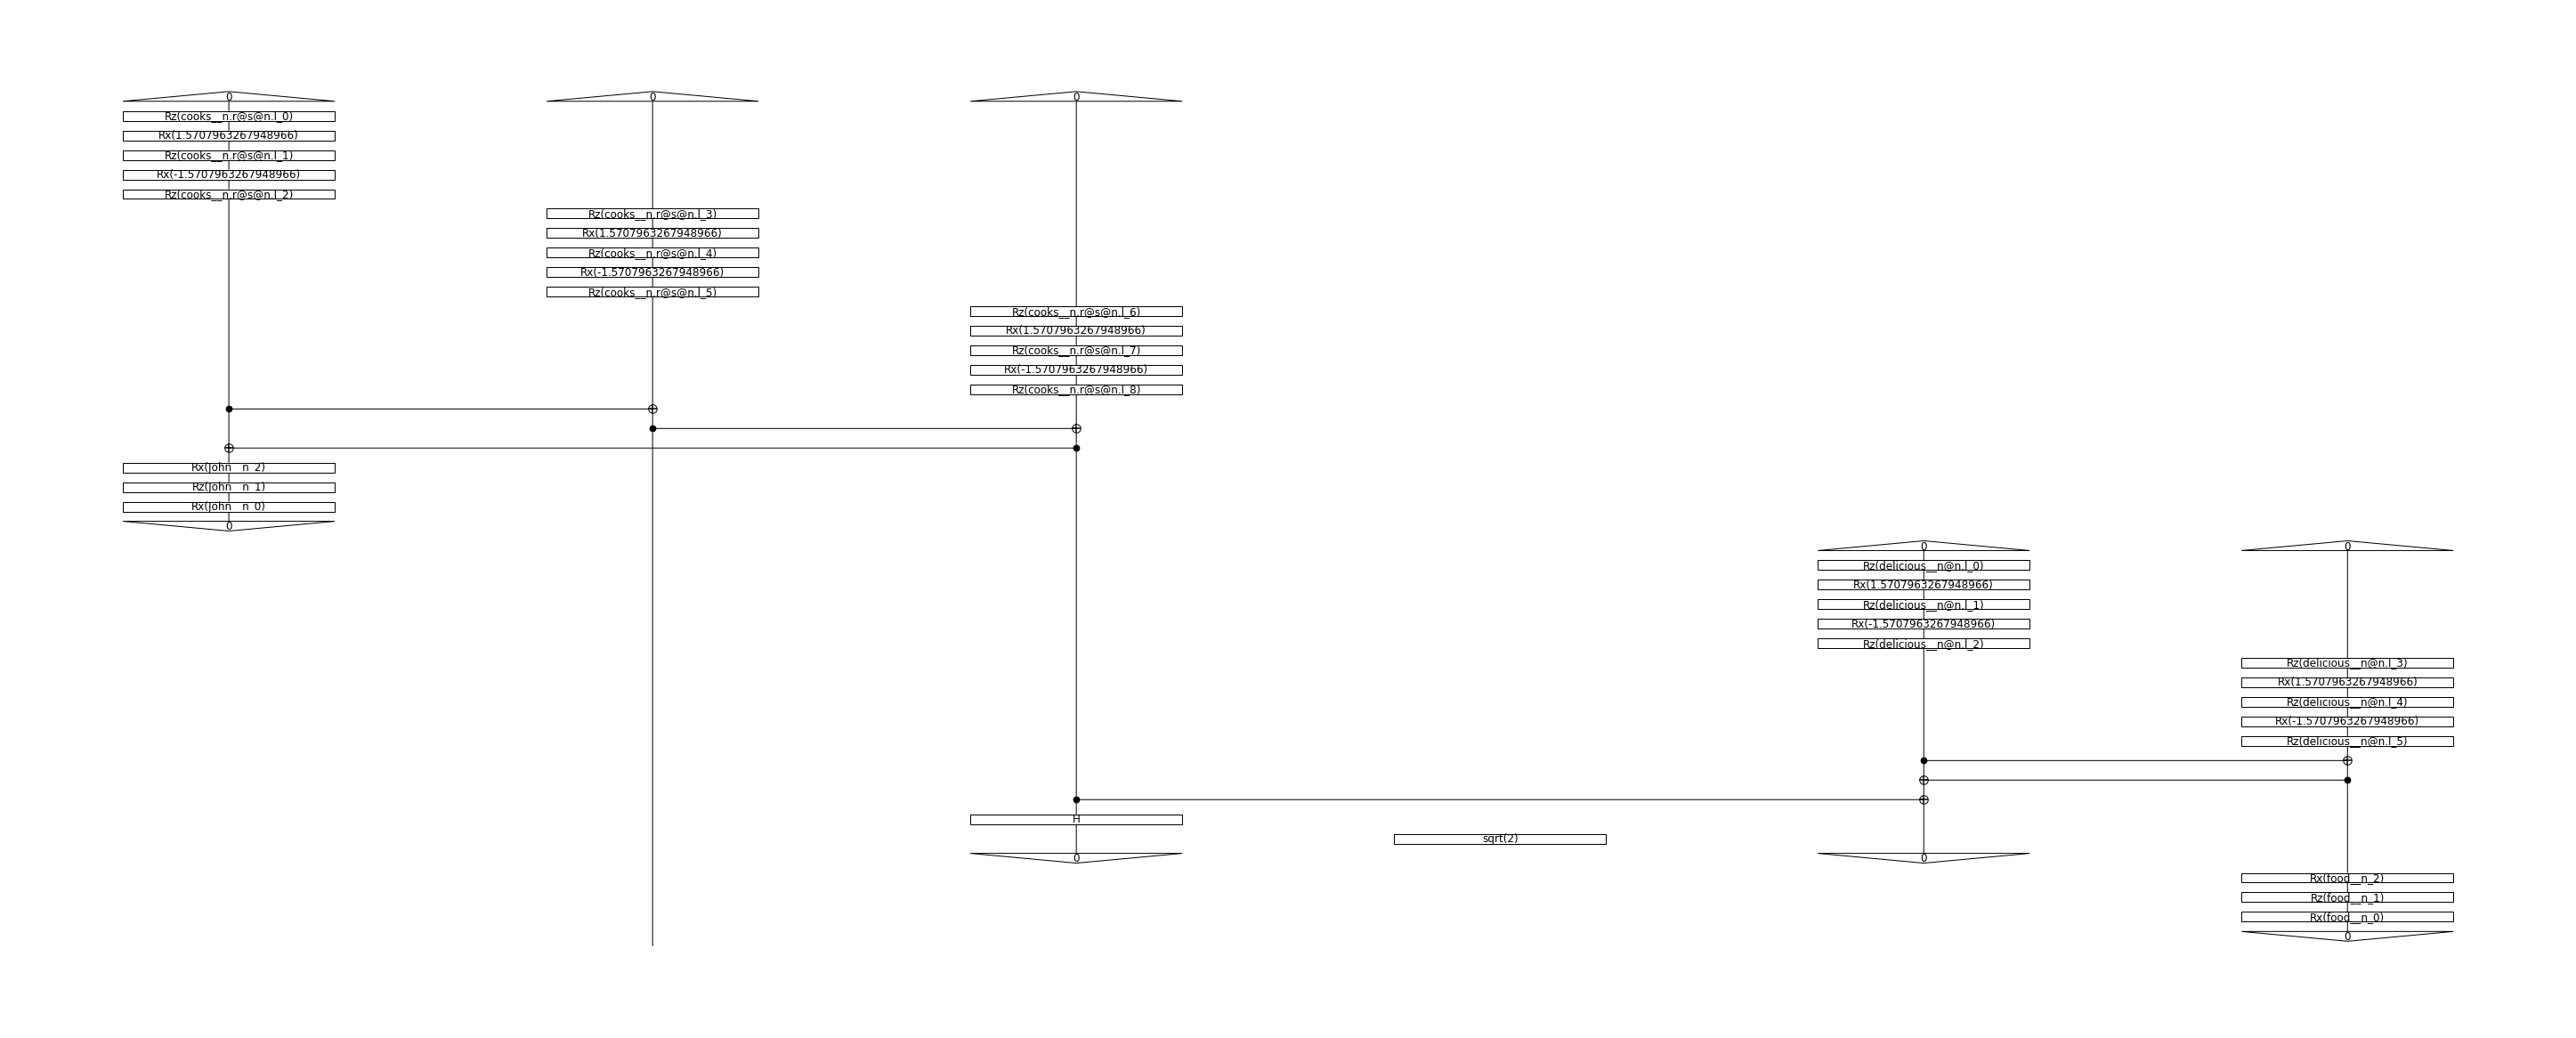

In [38]:
# Convert string diagram to qc - 1 qubit per atomic type
ansatz = CustomIQPAnsatz({N: 1, S: 1}, n_layers=1)
discopy_circuit = ansatz(decupped_diagram)
discopy_circuit.draw(figsize=(40, 16), fontsize=12)

### Custom Model Implementations

We modify the forward pass for the models to get the correct output.

In [39]:
class CustomTketModel(TketModel):
    def forward(self, x: list[[Diagram, Diagram]]) -> np.ndarray:
        # The forward pass takes x with 2 circuits
        # for each of the sentence being compared
        s1_diagrams = []
        s2_diagrams = []
        for s1d, s2d in x:
            s1_diagrams.append(s1d)
            s2_diagrams.append(s2d)
        
        s1_output = self.get_diagram_output(s1_diagrams)
        s2_output = self.get_diagram_output(s2_diagrams)
        
        s1_dot_s2 = np.sum(s1_output * s2_output, axis=1)
        complement = np.ones_like(s1_dot_s2) - s1_dot_s2
        # dot ~ 0 -> orthogonal -> corresponds to diff topic -> 0 label
        out = np.array([s1_dot_s2,
                        complement]).T

        return out

In [40]:
class CustomNumpyModel(NumpyModel):
    def forward(self, x: list[[Diagram, Diagram]]) -> np.ndarray:
        # The forward pass takes x with 2 circuits
        # for each of the sentence being compared
        s1_diagrams = []
        s2_diagrams = []
        for s1d, s2d in x:
            s1_diagrams.append(s1d)
            s2_diagrams.append(s2d)
        
        s1_output = self.get_diagram_output(s1_diagrams)
        s2_output = self.get_diagram_output(s2_diagrams)
        
        s1_dot_s2 = np.sum(s1_output * s2_output, axis=1)
        complement = np.ones_like(s1_dot_s2) - s1_dot_s2
        out = np.array([s1_dot_s2,
                        complement]).T

        return out

In [41]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat + 1e-6)) / len(y)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
eval_metrics = {"acc": acc}

### Training: Quantum case

Inspecting `grammar.json`:

In [42]:
import json

In [17]:
grammar_json_path = "/home/jovyan/.cache/lambeq/bobcat/bert/grammar.json"

In [18]:
with open(grammar_json_path, "r") as f:
    grammar_json = json.load(f)

Based on the sentence structures, we have the following grammatical structures. This might be important later.
- Noun
- Noun phrase
- Sentence
- Verb (transitive)
- Adjective

In [43]:
df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


In [44]:
df.shape

(100, 3)

In [45]:
df[df["label"] == 1].shape

(53, 3)

In [46]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

In [47]:
df_train_val, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [48]:
df_train_val.shape, df_test.shape

((90, 3), (10, 3))

In [49]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=4)

In [50]:
df_train_val.columns

Index(['s1', 's2', 'label'], dtype='object')

In [51]:
rskf_splits = list(rskf.split(df_train_val[["s1", "s2"]], y=df_train_val["label"]))

In [52]:
len(rskf_splits)

20

In [53]:
def preprocess_df(df, ansatz, verbose="text"):
    # Create raw diagram for both datasets.
    # We require both sentences to have a diagram
    # so it can be part of the dataset.
    df_out = df.copy(deep=True)
    df_out["s1_diagram"] = parser.sentences2diagrams(list(df_out["s1"].values), suppress_exceptions=True, verbose=verbose)
    df_out["s2_diagram"] = parser.sentences2diagrams(list(df_out["s2"].values), suppress_exceptions=True, verbose=verbose)
    df.dropna(inplace=True)

    # Convert to normal form
    df_out["s1_diagram"] = df_out["s1_diagram"].apply(lambda d: d.normal_form())
    df_out["s2_diagram"] = df_out["s2_diagram"].apply(lambda d: d.normal_form())

    # Vectorize label
    df_out["label_v"] = df_out["label"].apply(lambda l: [0, 1] if l == 0 else [1, 0])

    # Create circuits
    df_out["s1_circuit"] = df_out["s1_diagram"].apply(lambda d: ansatz(remove_cups(d)))
    df_out["s2_circuit"] = df_out["s2_diagram"].apply(lambda d: ansatz(remove_cups(d)))
    
    return df_out

In [54]:
qsn, qss, pn, d = (1, 1, 1, 1)

In [55]:
ansatz = CustomIQPAnsatz(
    {AtomicType.NOUN: qsn, AtomicType.SENTENCE: qss},
    n_layers=d,
    n_single_qubit_params=pn
)

In [56]:
rskf_splits[0][0].shape, rskf_splits[0][1].shape

((72,), (18,))

In [57]:
train_idx, val_idx = rskf_splits[0]
df_train, df_val = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]

In [58]:
print(df_train[df_train["label"] == 0].shape)
print(df_train[df_train["label"] == 1].shape)

(32, 3)
(40, 3)


In [58]:
preprocess_df(df_train, ansatz)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


,s1,s2,label,s1_diagram,s2_diagram,label_v,s1_circuit,s2_circuit
87,skilful chef creates meal,skilful hacker creates advanced code,0,"(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","[0, 1]","(((Ket(0, 0))), ((Rz(skilful__n@n.l_0) @ Id(1)...","(((Ket(0, 0))), ((Rz(skilful__n@n.l_0) @ Id(1)..."
74,hacker creates advanced code,programmer creates code,1,"(((hacker)), ((Id(n) @ creates)), ((Cup(n, n.r...","(((programmer)), ((Id(n) @ creates)), ((Cup(n,...","[1, 0]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ..."
12,cook creates complicated dish,hacker writes code,0,"(((cook)), ((Id(n) @ creates)), ((Cup(n, n.r) ...","(((hacker)), ((Id(n) @ writes)), ((Cup(n, n.r)...","[0, 1]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(writes__n.r@s@n.l_0) @..."
96,programmer creates code,chef creates dish,0,"(((programmer)), ((Id(n) @ creates)), ((Cup(n,...","(((chef)), ((Id(n) @ creates)), ((Cup(n, n.r) ...","[0, 1]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ..."
22,cook creates meal,chef prepares complicated dish,1,"(((cook)), ((Id(n) @ creates)), ((Cup(n, n.r) ...","(((chef)), ((Id(n) @ prepares)), ((Cup(n, n.r)...","[1, 0]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(prepares__n.r@s@n.l_0)..."
...,...,...,...,...,...,...,...,...
27,chef prepares meal,skilful chef creates tasty dish,1,"(((chef)), ((Id(n) @ prepares)), ((Cup(n, n.r)...","(((skilful)), ((Id(n) @ creates @ Id(n.l))), (...","[1, 0]","(((Ket(0, 0, 0))), ((Rz(prepares__n.r@s@n.l_0)...","(((Ket(0, 0))), ((Rz(skilful__n@n.l_0) @ Id(1)..."
8,hacker creates code,programmer creates complicated code,1,"(((hacker)), ((Id(n) @ creates)), ((Cup(n, n.r...","(((programmer)), ((Id(n) @ creates)), ((Cup(n,...","[1, 0]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ..."
56,devoted hacker writes code,experienced cook creates meal,0,"(((devoted)), ((Id(n) @ writes @ Id(n.l))), ((...","(((experienced)), ((Id(n) @ creates @ Id(n.l))...","[0, 1]","(((Ket(0, 0))), ((Rz(devoted__n@n.l_0) @ Id(1)...","(((Ket(0, 0))), ((Rz(experienced__n@n.l_0) @ I..."
26,cook creates complicated meal,cook prepares dish,1,"(((cook)), ((Id(n) @ creates)), ((Cup(n, n.r) ...","(((cook)), ((Id(n) @ prepares)), ((Cup(n, n.r)...","[1, 0]","(((Ket(0, 0, 0))), ((Rz(creates__n.r@s@n.l_0) ...","(((Ket(0, 0, 0))), ((Rz(prepares__n.r@s@n.l_0)..."


In [59]:
df_train.head()

,s1,s2,label
87,skilful chef creates meal,skilful hacker creates advanced code,0
74,hacker creates advanced code,programmer creates code,1
12,cook creates complicated dish,hacker writes code,0
96,programmer creates code,chef creates dish,0
22,cook creates meal,chef prepares complicated dish,1


In [60]:
df_train["s1_diagram"][40].draw(figsize=(4, 3), fontsize=12)

KeyError: 's1_diagram'

In [ ]:
df_train["s2_diagram"][40].draw(figsize=(4, 3), fontsize=12)

In [ ]:
df_train["s1_circuit"][40].draw(figsize=(4, 3), fontsize=12)

In [ ]:
df_train["s2_circuit"][40].draw(figsize=(4, 3), fontsize=12)

In [ ]:
render_circuit_jupyter(df_train["s1_circuit"][40].to_tk())

In [ ]:
render_circuit_jupyter(df_train["s2_circuit"][40].to_tk())

In [ ]:
preprocess_df(df_val, ansatz)

In [ ]:
preprocess_df(df_test, ansatz)

In [ ]:
train_circuits = list(df_train[["s1_circuit", "s2_circuit"]].values)
val_circuits = list(df_val[["s1_circuit", "s2_circuit"]].values)
test_circuits = list(df_test[["s1_circuit", "s2_circuit"]].values)

In [ ]:
all_circuits = train_circuits + val_circuits + test_circuits

In [ ]:
assert len(all_circuits) == len(df)

In [ ]:
train_diagrams = list(df_train[["s1_diagram", "s2_diagram"]].values)
val_diagrams = list(df_val[["s1_diagram", "s2_diagram"]].values)
test_diagrams = list(df_test[["s1_diagram", "s2_diagram"]].values)

In [ ]:
all_diagrams = train_diagrams + val_diagrams + test_diagrams             

In [ ]:
train_labels = list(df_train["label_v"].values)
val_labels = list(df_val["label_v"].values)
test_labels = list(df_test["label_v"].values)

In [ ]:
backend = AerBackend()
backend_config = {
    "backend": backend,
    "compilation": backend.default_compilation_pass(2),
    "shots": 2**12,
}

In [ ]:
np.array(all_circuits).reshape(-1).shape

In [59]:
BATCH_SIZE = 32
EPOCHS = 500

In [ ]:
train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

In [ ]:
val_dataset = Dataset(val_circuits,
                      val_labels,
                      shuffle=False)

In [ ]:
tket_model = CustomTketModel.from_diagrams(np.array(all_circuits).reshape(-1),
                                           backend_config=backend_config)

In [ ]:
npy_model = CustomNumpyModel.from_diagrams(np.array(all_circuits).reshape(-1),
                                           use_jit=True)
                                           #backend_config=backend_config)

In [ ]:
tket_trainer = QuantumTrainer(
    tket_model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={"a": 0.05, "c": 0.06, "A": 0.01 * EPOCHS},
    evaluate_functions=eval_metrics,
    verbose="text",
    # from_checkpoint=True,
    # log_dir="runs/Aug12_08-52-24_jupyter-neiljohn-2eortega-40gmail-2ecom/",
    seed=RANDOM_SEED,
)

In [60]:
def run_experiment(df_train_val,
                   train_val_splits,
                   df_test,
                   model_cls=NumpyModel,
                   model_params={"use_jit": True},
                   ansatz_cls=IQPAnsatz,
                   ansatz_params=(1, 1, 1, 1,),
                   batch_size=32,
                   epochs=50,
                   loss=loss,
                   optimizer=SPSAOptimizer,
                   optim_hyperparams={"a": 0.05, "c": 0.06},
                   eval_metrics={"acc": acc},
                   eval_step=5,
                   log_step=5,
                   random_seed=None,
                   verbose="text"):
    # For each experiment, we vary
    # 1. Word ansatz
    # 2. Ansatz configuration
    # 3. Model class, i.e. tket vs numpy
    #    (mostly for performance, as tket models take longer to train)
    
    qsn, qss, pn, d = ansatz_params
    
    ansatz = ansatz_cls({
        AtomicType.NOUN: qsn,
        AtomicType.SENTENCE: qss
    }, n_single_qubit_params=pn, n_layers=d)

    # Need to preprocess testing dataset, as well
    df_test_procd = preprocess_df(df_test, ansatz, verbose="suppress")
    test_circs = list(df_test_procd[["s1_circuit", "s2_circuit"]].values)
    test_labels = list(df_test_procd["label_v"].values)
    
    # Metrics to collect
    log_dirs = []
    train_costs = []
    val_costs = []
    train_results = {k: [] for k in eval_metrics}
    val_results = {k: [] for k in eval_metrics}
    val_metrics = {k: [] for k in eval_metrics}
    
    for i, (train_idx, val_idx) in enumerate(train_val_splits):
        print(f"Training for split {i+1}/{len(train_val_splits)}.")
        df_train, df_val = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]
        df_train_procd = preprocess_df(df_train, ansatz, verbose="suppress")
        df_val_procd = preprocess_df(df_val, ansatz, verbose="suppress")
        
        # Get circuits
        train_circs = list(df_train_procd[["s1_circuit", "s2_circuit"]].values)
        val_circs = list(df_val_procd[["s1_circuit", "s2_circuit"]].values)
        all_circs = train_circs + val_circs + test_circs
        
        # Get labels
        train_labels = list(df_train_procd["label_v"].values)
        val_labels = list(df_val_procd["label_v"].values)

        # Create datasets
        train_ds = Dataset(train_circs, train_labels, batch_size=batch_size)
        val_ds = Dataset(val_circs, val_labels, shuffle=False)
        
        # Create model
        model = model_cls.from_diagrams(np.array(all_circs).reshape(-1),
                                        **model_params)
        
        # Create trainer
        optim_hyperparams["A"] = 0.01 * epochs
        trainer = QuantumTrainer(
            model,
            loss_function=loss,
            epochs=epochs,
            optimizer=optimizer,
            optim_hyperparams=optim_hyperparams,
            evaluate_functions=eval_metrics,
            verbose=verbose,
            # from_checkpoint=True,
            # log_dir="runs/Aug12_08-52-24_jupyter-neiljohn-2eortega-40gmail-2ecom/",
            seed=random_seed,
        )
        
        # Fit model
        trainer.fit(train_ds, val_ds, evaluation_step=eval_step, logging_step=log_step)
        
        # Collect metrics
        log_dirs.append(trainer.log_dir)
        train_costs.append(trainer.train_epoch_costs)
        val_costs.append(trainer.val_costs)
        for k in eval_metrics:
            train_results[k].append(trainer.train_results[k])
            val_results[k].append(trainer.val_results[k])
            val_metrics[k].append(
                eval_metrics[k](model(val_circs), val_labels)
            )

        # print test accuracy
        val_metrics_i = {k: func(model(val_circs), val_labels) for k, func in eval_metrics.items()}
        print(f"Validation metrics for split {i+1}/{len(train_val_splits)}:")
        print(val_metrics_i)
    
   
    return {
        "log_dirs": log_dirs,
        "train_costs": train_costs,
        "val_costs": val_costs,
        "train_results": train_results,
        "val_results": val_results,
        "val_metrics": val_metrics,
    }

In [68]:
# Collect several experimental results for different
# ansatz, config, etc.
import itertools

qsns = [1, 2]
qsss = [1]
pns = [1, 3]
ds = [1, 2]

ansatz_params_lists = itertools.product(qsns, qsss, pns, ds)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

all_experiments_out = {}
for ansatz_cls in [IQPAnsatz, CustomIQPAnsatz]:
    for ansatz_params in ansatz_params_lists:
        experiment_label = f"{ansatz_cls.__name__}_{ansatz_params}"
        print(f"Training experiment '{experiment_label}'.")
        experiment_out = run_experiment(
            df_train_val, rskf_splits[:2], df_test,
            model_cls=CustomNumpyModel,
            ansatz_cls=ansatz_cls,
            ansatz_params=ansatz_params,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            loss=loss,
            optimizer=SPSAOptimizer,
            optim_hyperparams={"a": 0.05, "c": 0.06},
            eval_metrics={"acc": acc},
            eval_step=5,
            log_step=5,
            random_seed=RANDOM_SEED,
            verbose="text"
        )
        all_experiments_out[experiment_label] = experiment_out
        print("Done.")

Training experiment 'IQPAnsatz_(1, 1, 1, 1)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.7165   valid/loss: 0.7582   train/acc: 0.5139   valid/acc: 0.3333
Epoch 5:  train/loss: 0.6921   valid/loss: 0.7582   train/acc: 0.5694   valid/acc: 0.3333

Training completed!


Validation metrics for split 1/2:
{'acc': 0.3333333333333333}
Training for split 2/2.


Epoch 1:  train/loss: 0.7171   valid/loss: 0.7197   train/acc: 0.5278   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6923   valid/loss: 0.7197   train/acc: 0.5556   valid/acc: 0.6667

Training completed!


Validation metrics for split 2/2:
{'acc': 0.6111111111111112}
Done.
Training experiment 'IQPAnsatz_(1, 1, 1, 2)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.6978   valid/loss: 0.6869   train/acc: 0.5000   valid/acc: 0.5556
Epoch 5:  train/loss: 0.6986   valid/loss: 0.6869   train/acc: 0.5278   valid/acc: 0.5556

Training completed!


Validation metrics for split 1/2:
{'acc': 0.6111111111111112}
Training for split 2/2.


Epoch 1:  train/loss: 0.6856   valid/loss: 0.7097   train/acc: 0.5556   valid/acc: 0.5556
Epoch 5:  train/loss: 0.6880   valid/loss: 0.7097   train/acc: 0.5139   valid/acc: 0.5556

Training completed!


Validation metrics for split 2/2:
{'acc': 0.5}
Done.
Training experiment 'IQPAnsatz_(1, 1, 3, 1)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.6887   valid/loss: 0.7069   train/acc: 0.5556   valid/acc: 0.6111
Epoch 5:  train/loss: 0.6768   valid/loss: 0.7069   train/acc: 0.5972   valid/acc: 0.6111

Training completed!


Validation metrics for split 1/2:
{'acc': 0.3888888888888889}
Training for split 2/2.


Epoch 1:  train/loss: 0.6893   valid/loss: 0.7058   train/acc: 0.6250   valid/acc: 0.5000
Epoch 5:  train/loss: 0.6947   valid/loss: 0.7058   train/acc: 0.5417   valid/acc: 0.5000

Training completed!


Validation metrics for split 2/2:
{'acc': 0.5555555555555556}
Done.
Training experiment 'IQPAnsatz_(1, 1, 3, 2)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.6768   valid/loss: 0.6452   train/acc: 0.5556   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6736   valid/loss: 0.6452   train/acc: 0.5556   valid/acc: 0.6667

Training completed!


Validation metrics for split 1/2:
{'acc': 0.7222222222222222}
Training for split 2/2.


Epoch 1:  train/loss: 0.6843   valid/loss: 0.6865   train/acc: 0.5556   valid/acc: 0.5556
Epoch 5:  train/loss: 0.6570   valid/loss: 0.6865   train/acc: 0.6389   valid/acc: 0.5556

Training completed!


Validation metrics for split 2/2:
{'acc': 0.4444444444444444}
Done.
Training experiment 'IQPAnsatz_(2, 1, 1, 1)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.7126   valid/loss: 0.6158   train/acc: 0.5972   valid/acc: 0.8333
Epoch 5:  train/loss: 0.6391   valid/loss: 0.6158   train/acc: 0.6528   valid/acc: 0.8333

Training completed!


Validation metrics for split 1/2:
{'acc': 0.7777777777777778}
Training for split 2/2.


Epoch 1:  train/loss: 0.6995   valid/loss: 0.6690   train/acc: 0.6389   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6422   valid/loss: 0.6690   train/acc: 0.6389   valid/acc: 0.6667

Training completed!


Validation metrics for split 2/2:
{'acc': 0.6111111111111112}
Done.
Training experiment 'IQPAnsatz_(2, 1, 1, 2)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.6905   valid/loss: 0.6973   train/acc: 0.5833   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6991   valid/loss: 0.6973   train/acc: 0.5417   valid/acc: 0.6667

Training completed!


Validation metrics for split 1/2:
{'acc': 0.6111111111111112}
Training for split 2/2.


Epoch 1:  train/loss: 0.6969   valid/loss: 0.6838   train/acc: 0.5417   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6881   valid/loss: 0.6838   train/acc: 0.5833   valid/acc: 0.6667

Training completed!


Validation metrics for split 2/2:
{'acc': 0.7222222222222222}
Done.
Training experiment 'IQPAnsatz_(2, 1, 3, 1)'.
Training for split 1/2.


Epoch 1:  train/loss: 0.7126   valid/loss: 0.6158   train/acc: 0.5972   valid/acc: 0.8333
Epoch 5:  train/loss: 0.6391   valid/loss: 0.6158   train/acc: 0.6528   valid/acc: 0.8333

Training completed!


Validation metrics for split 1/2:
{'acc': 0.7777777777777778}
Training for split 2/2.


Epoch 1:  train/loss: 0.6995   valid/loss: 0.6690   train/acc: 0.6389   valid/acc: 0.6667
Epoch 5:  train/loss: 0.6422   valid/loss: 0.6690   train/acc: 0.6389   valid/acc: 0.6667

Training completed!


Validation metrics for split 2/2:
{'acc': 0.6111111111111112}
Done.
Training experiment 'IQPAnsatz_(2, 1, 3, 2)'.
Training for split 1/2.


In [ ]:
all_experiments_out

In [190]:
tket_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

KeyboardInterrupt: 

In [135]:
tket_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:     train/loss: 0.9037   valid/loss: 1.8953   train/acc: 0.6406   valid/acc: 0.3125
Epoch 2:     train/loss: 0.7223   valid/loss: 1.1375   train/acc: 0.5938   valid/acc: 0.3750
Epoch 3:     train/loss: 0.6824   valid/loss: 0.9230   train/acc: 0.5938   valid/acc: 0.3750
Epoch 4:     train/loss: 0.9927   valid/loss: 1.3406   train/acc: 0.5469   valid/acc: 0.2500
Epoch 5:     train/loss: 0.7703   valid/loss: 0.9556   train/acc: 0.5703   valid/acc: 0.4062
Epoch 6:     train/loss: 0.9581   valid/loss: 0.9449   train/acc: 0.6719   valid/acc: 0.5000
Epoch 7:     train/loss: 1.1552   valid/loss: 0.6400   train/acc: 0.6094   valid/acc: 0.7188
Epoch 8:     train/loss: 0.8387   valid/loss: 0.9968   train/acc: 0.5781   valid/acc: 0.4375
Epoch 9:     train/loss: 0.7496   valid/loss: 0.7159   train/acc: 0.5078   valid/acc: 0.4688
Epoch 10:    train/loss: 0.9604   valid/loss: 0.6972   train/acc: 0.6016   valid/acc: 0.5000
Epoch 11:    train/loss: 0.9510   valid/loss: 0.7907   train/acc: 0.53

KeyboardInterrupt: 

In [191]:
npy_trainer = QuantumTrainer(
    npy_model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={"a": 0.05, "c": 0.06, "A": 0.01 * EPOCHS},
    evaluate_functions=eval_metrics,
    verbose="text",
    # from_checkpoint=True,
    # log_dir="runs/Aug12_08-52-24_jupyter-neiljohn-2eortega-40gmail-2ecom/",
    seed=RANDOM_SEED,
)

In [192]:
npy_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:    train/loss: 0.6868   valid/loss: 0.6688   train/acc: 0.5625   valid/acc: 0.6250
Epoch 2:    train/loss: 0.6802   valid/loss: 0.6671   train/acc: 0.5938   valid/acc: 0.6250
Epoch 3:    train/loss: 0.6916   valid/loss: 0.6737   train/acc: 0.5938   valid/acc: 0.4375
Epoch 4:    train/loss: 0.6997   valid/loss: 0.6719   train/acc: 0.4844   valid/acc: 0.4375
Epoch 5:    train/loss: 0.6803   valid/loss: 0.6711   train/acc: 0.5781   valid/acc: 0.4375
Epoch 6:    train/loss: 0.7065   valid/loss: 0.6750   train/acc: 0.5156   valid/acc: 0.4375
Epoch 7:    train/loss: 0.6776   valid/loss: 0.6751   train/acc: 0.6094   valid/acc: 0.3750
Epoch 8:    train/loss: 0.7047   valid/loss: 0.6698   train/acc: 0.5156   valid/acc: 0.4375
Epoch 9:    train/loss: 0.6692   valid/loss: 0.6691   train/acc: 0.5938   valid/acc: 0.4375
Epoch 10:   train/loss: 0.6813   valid/loss: 0.6730   train/acc: 0.6406   valid/acc: 0.4375
Epoch 11:   train/loss: 0.6885   valid/loss: 0.6749   train/acc: 0.5469   valid/

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey="row",
                                                     figsize=(12, 12))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(npy_trainer.train_epoch_costs[::], color=next(colours))
ax_bl.plot(npy_trainer.train_results['acc'][::], color=next(colours))
ax_tr.plot(npy_trainer.val_costs[::], color=next(colours))
ax_br.plot(npy_trainer.val_results['acc'][::], color=next(colours))

# print test accuracy
test_acc = acc(npy_model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

In [138]:
npy_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:     train/loss: 0.6986   valid/loss: 0.7235   train/acc: 0.5469   valid/acc: 0.4375
Epoch 2:     train/loss: 0.6637   valid/loss: 0.7144   train/acc: 0.6094   valid/acc: 0.4375
Epoch 3:     train/loss: 0.6678   valid/loss: 0.7142   train/acc: 0.6250   valid/acc: 0.4375
Epoch 4:     train/loss: 0.6883   valid/loss: 0.7283   train/acc: 0.5938   valid/acc: 0.3750
Epoch 5:     train/loss: 0.6708   valid/loss: 0.7284   train/acc: 0.5625   valid/acc: 0.3750
Epoch 6:     train/loss: 0.6648   valid/loss: 0.7240   train/acc: 0.5625   valid/acc: 0.4375
Epoch 7:     train/loss: 0.6582   valid/loss: 0.7254   train/acc: 0.5938   valid/acc: 0.4375
Epoch 8:     train/loss: 0.6409   valid/loss: 0.7188   train/acc: 0.7031   valid/acc: 0.5000
Epoch 9:     train/loss: 0.6551   valid/loss: 0.7153   train/acc: 0.5938   valid/acc: 0.5000
Epoch 10:    train/loss: 0.6620   valid/loss: 0.7191   train/acc: 0.5781   valid/acc: 0.4375
Epoch 11:    train/loss: 0.6497   valid/loss: 0.7178   train/acc: 0.62

KeyboardInterrupt: 

In [138]:
npy_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=1)

Epoch 1:     train/loss: 0.6986   valid/loss: 0.7235   train/acc: 0.5469   valid/acc: 0.4375
Epoch 2:     train/loss: 0.6637   valid/loss: 0.7144   train/acc: 0.6094   valid/acc: 0.4375
Epoch 3:     train/loss: 0.6678   valid/loss: 0.7142   train/acc: 0.6250   valid/acc: 0.4375
Epoch 4:     train/loss: 0.6883   valid/loss: 0.7283   train/acc: 0.5938   valid/acc: 0.3750
Epoch 5:     train/loss: 0.6708   valid/loss: 0.7284   train/acc: 0.5625   valid/acc: 0.3750
Epoch 6:     train/loss: 0.6648   valid/loss: 0.7240   train/acc: 0.5625   valid/acc: 0.4375
Epoch 7:     train/loss: 0.6582   valid/loss: 0.7254   train/acc: 0.5938   valid/acc: 0.4375
Epoch 8:     train/loss: 0.6409   valid/loss: 0.7188   train/acc: 0.7031   valid/acc: 0.5000
Epoch 9:     train/loss: 0.6551   valid/loss: 0.7153   train/acc: 0.5938   valid/acc: 0.5000
Epoch 10:    train/loss: 0.6620   valid/loss: 0.7191   train/acc: 0.5781   valid/acc: 0.4375
Epoch 11:    train/loss: 0.6497   valid/loss: 0.7178   train/acc: 0.62

KeyboardInterrupt: 

In [139]:
import matplotlib.pyplot as plt

Validation accuracy: 1.0


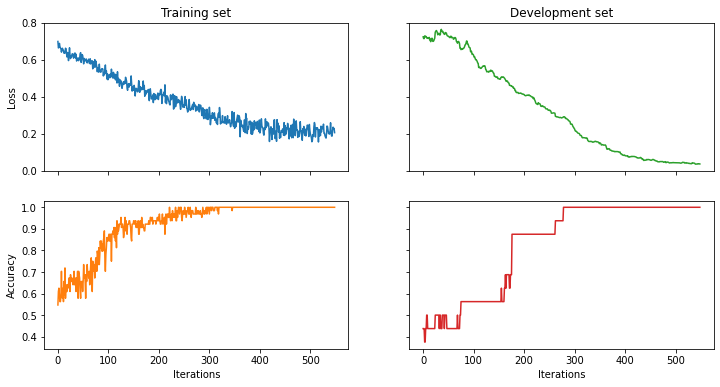

In [142]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey="row",
                                                     figsize=(12, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(npy_trainer.train_epoch_costs[::], color=next(colours))
ax_bl.plot(npy_trainer.train_results['acc'][::], color=next(colours))
ax_tr.plot(npy_trainer.val_costs[::], color=next(colours))
ax_br.plot(npy_trainer.val_results['acc'][::], color=next(colours))

# print test accuracy
test_acc = acc(npy_model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

Validation accuracy: 1.0


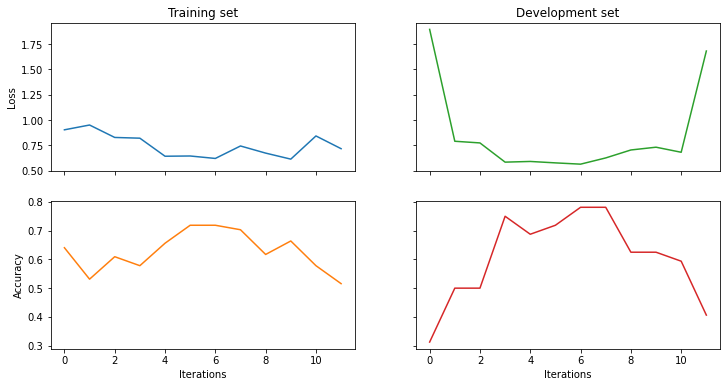

In [140]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey="row",
                                                     figsize=(12, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(npy_model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())

In [89]:
log_dir = trainer.log_dir
log_dir

'runs/Aug12_15-04-37_jupyter-neiljohn-2eortega-40gmail-2ecom'

In [ ]:
tket_model.make_checkpoint("./checkpoints")

### Aside: What happens during the forward pass?

In [55]:
from discopy.quantum import Circuit

In [52]:
all_circuits[0]

Circuit(dom=Ty(), cod=qubit, boxes=[Ket(0, 0, 0), H, H, H, Controlled(Rz(creates__n.r@s@n.l_0), distance=1), Controlled(Rz(creates__n.r@s@n.l_1), distance=1), Rx(hacker__n_2), Rz(hacker__n_1), Rx(hacker__n_0), Bra(0), Rx(code__n_2), Rz(code__n_1), Rx(code__n_0), Bra(0)], offsets=[0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

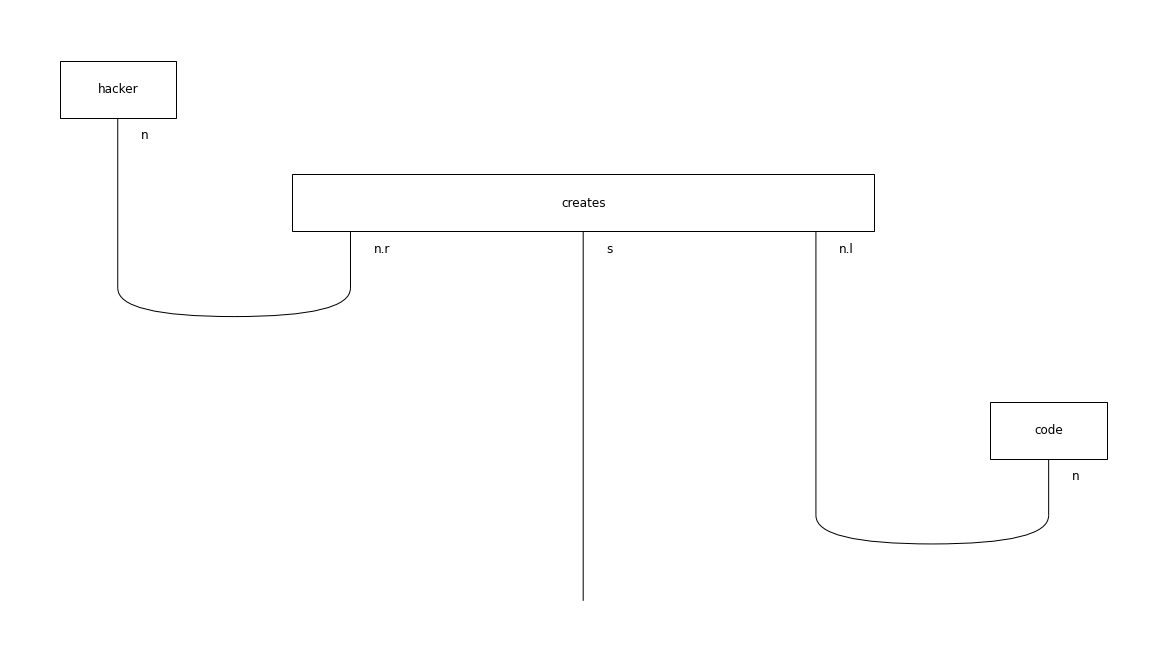

In [74]:
all_diagrams[0].draw(figsize=(16, 9), fontsize=12)

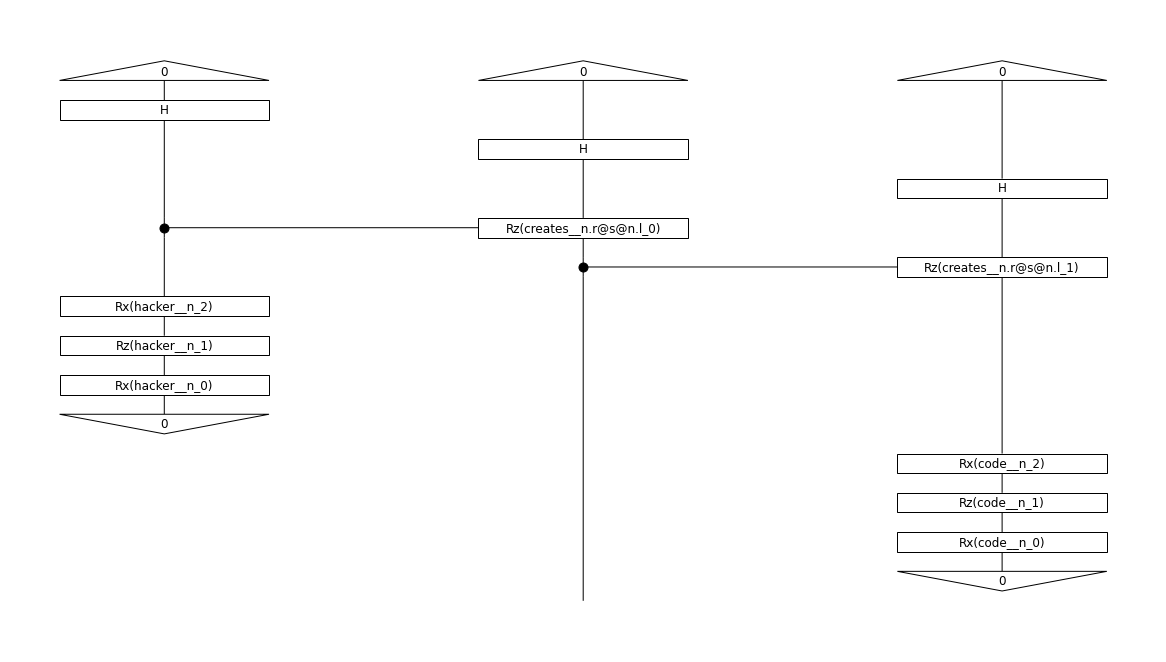

In [59]:
all_circuits[0].draw(figsize=(16, 9), fontsize=12)

In [58]:
render_circuit_jupyter(all_circuits[0].to_tk())

In [54]:
lambdified_diagram = model._make_lambda(all_circuits[0])

In [62]:
type(lambdified_diagram)

function

In [68]:
model.weights.shape

(33,)

In [72]:
lambdified_diagram(*model.weights)

Circuit(dom=Ty(), cod=bit, boxes=[Ket(0, 0, 0), H, H, H, Controlled(Rz(0.14), distance=1), Controlled(Rz(0.798), distance=1), Rx(0.502), Rz(0.434), Rx(0.628), Bra(0), Rx(0.936), Rz(0.0306), Rx(0.563), Bra(0), Measure()], offsets=[0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [56]:
tensors = Circuit.eval(
    *lambdified_diagram(*model.weights),
    **model.backend_config,
    seed=model._randint(),
)

In [61]:
tensors

[Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(1), array=[1.+0.j]),
 Tensor(dom=Dim(1), cod=Dim(2), array=[1.+0.j, 0.+0.j])]

In [66]:
np.array([model._normalise_vector(t.array) for t in tensors])

array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, array([9.99999999e-01, 9.99999998e-10])], dtype=object)

## Questions/Notes

- What is getting measured?
- Domain = input, codomain = output, box = function
- Model must receive __ALL__ circuits during init - including all datasplits. This is similar to sequence models having a fixed sequence length during init.

### Debugging

In [52]:
model = CustomNumpyModel.from_diagrams(np.array(all_circuits).reshape(-1),
                                       use_jit=True,)
                                       # backend_config=backend_config)

NameError: name 'CustomNumpyModel' is not defined

In [ ]:
# Customize QuantumTrainer
from abc import ABC, abstractmethod
from collections.abc import Callable, Mapping
from datetime import datetime
from math import ceil
import os
import random
import socket
import sys
from typing import Any, Optional, Union
from typing import TYPE_CHECKING

from discopy import Tensor
from tqdm.notebook import tqdm, trange

if TYPE_CHECKING:
    from torch.utils.tensorboard import SummaryWriter

from lambeq.core.globals import VerbosityLevel
from lambeq.training.checkpoint import Checkpoint
from lambeq.training.dataset import Dataset
from lambeq.training.model import Model


def _import_tensorboard_writer() -> None:
    global SummaryWriter
    try:
        from torch.utils.tensorboard import SummaryWriter
    except ImportError:  # pragma: no cover
        raise ImportError('tensorboard not found. Please install it using '
                          '`pip install tensorboard`.')


_StrPathT = Union[str, 'os.PathLike[str]']


class CustomQuantumTrainer(QuantumTrainer):
    def fit(self,
            train_dataset: Dataset,
            val_dataset: Optional[Dataset] = None,
            evaluation_step: int = 1,
            logging_step: int = 1) -> None:
        """Fit the model on the training data and, optionally,
        evaluate it on the validation data.

        Parameters
        ----------
        train_dataset : :py:class:`Dataset`
            Dataset used for training.
        val_dataset : :py:class:`Dataset`, optional
            Validation dataset.
        evaluation_step : int, default: 1
            Sets the intervals at which the metrics are evaluated on the
            validation dataset.
        logging_step : int, default: 1
            Sets the intervals at which the training statistics are
            printed if `verbose = 'text'` (otherwise ignored).

        """
        if self.from_checkpoint:
            self._load_extra_chkpoint_info(self.checkpoint)

        def writer_helper(*args: Any) -> None:
            if self.use_tensorboard:
                self.writer.add_scalar(*args)
            else:
                print(*args)

        # initialise progress bar
        step = self.start_step
        batches_per_epoch = ceil(len(train_dataset)/train_dataset.batch_size)
        status_bar = tqdm(total=float('inf'),
                          bar_format='{desc}',
                          desc=self._generate_stat_report(),
                          disable=(
                                self.verbose != VerbosityLevel.PROGRESS.value),
                          leave=True,
                          position=0)

        # start training loop
        for epoch in trange(self.start_epoch,
                            self.epochs,
                            desc='Epoch',
                            disable=(
                                self.verbose != VerbosityLevel.PROGRESS.value),
                            leave=False,
                            position=1):
            train_loss = 0.0
            with Tensor.backend(self.backend):
                for batch in tqdm(train_dataset,
                                  desc='Batch',
                                  total=batches_per_epoch,
                                  disable=(self.verbose
                                           != VerbosityLevel.PROGRESS.value),
                                  leave=False,
                                  position=2):
                    step += 1
                    x, y_label = batch
                    y_hat, loss = self.training_step(batch)
                    if (self.evaluate_on_train
                            and self.evaluate_functions is not None):
                        for metr, func in self.evaluate_functions.items():
                            res = func(y_hat, y_label)
                            metric = self._train_results_epoch[metr]
                            metric.append(len(x) * res)
                    train_loss += len(batch[0]) * loss
                    writer_helper('train/step_loss', loss, step)
                    status_bar.set_description(
                            self._generate_stat_report(
                                train_loss=loss,
                                val_loss=(self.val_costs[-1] if self.val_costs
                                          else None)))
            train_loss /= len(train_dataset)
            self.train_epoch_costs.append(train_loss)
            writer_helper('train/epoch_loss', train_loss, epoch + 1)

            # evaluate on train
            if (self.evaluate_on_train
                    and self.evaluate_functions is not None):
                for name in self._train_results_epoch:
                    self.train_results[name].append(
                        sum(self._train_results_epoch[name])/len(train_dataset)
                    )
                    self._train_results_epoch[name] = []  # reset
                    writer_helper(
                        f'train/{name}', self.train_results[name][-1],
                        epoch+1)
                    if self.verbose == VerbosityLevel.PROGRESS.value:
                        status_bar.set_description(
                                self._generate_stat_report(
                                    train_loss=train_loss,
                                    val_loss=(self.val_costs[-1]
                                              if self.val_costs else None)))

            # evaluate metrics on validation data
            if val_dataset is not None:
                if epoch % evaluation_step == 0:
                    val_loss = 0.0
                    batches_per_validation = ceil(len(val_dataset)
                                                  / val_dataset.batch_size)
                    writer_helper('batches_per_validation', batches_per_validation, len(val_dataset), val_dataset.batch_size)
                    with Tensor.backend(self.backend):
                        disable_tqdm = (self.verbose
                                        != VerbosityLevel.PROGRESS.value)
                        for v_batch in tqdm(val_dataset,
                                            desc='Validation batch',
                                            total=batches_per_validation,
                                            disable=disable_tqdm,
                                            leave=False,
                                            position=2):
                            writer_helper("***", v_batch)
                            x_val, y_label_val = v_batch
                            writer_helper("***", x_val, y_label_val)
                            y_hat_val, cur_loss = self.validation_step(v_batch)
                            writer_helper("***", y_hat_val, cur_loss)
                            val_loss += cur_loss * len(x_val)
                            if self.evaluate_functions is not None:
                                for metr, func in (
                                        self.evaluate_functions.items()):
                                    res = func(y_hat_val, y_label_val)
                                    self._val_results_epoch[metr].append(
                                        len(x_val)*res)
                            status_bar.set_description(
                                    self._generate_stat_report(
                                        train_loss=train_loss,
                                        val_loss=val_loss))
                        val_loss /= len(val_dataset)
                        self.val_costs.append(val_loss)
                        status_bar.set_description(
                                self._generate_stat_report(
                                    train_loss=train_loss,
                                    val_loss=val_loss))
                        writer_helper('val/loss', val_loss, epoch+1)

                    if self.evaluate_functions is not None:
                        for name in self._val_results_epoch:
                            self.val_results[name].append(
                                sum(self._val_results_epoch[name])
                                / len(val_dataset))
                            self._val_results_epoch[name] = []  # reset
                            writer_helper(
                                f'val/{name}', self.val_results[name][-1],
                                epoch + 1)
                            status_bar.set_description(
                                    self._generate_stat_report(
                                        train_loss=train_loss,
                                        val_loss=val_loss))
            # save checkpoint info
            save_dict = {'epoch': epoch+1,
                         'model_weights': self.model.weights,
                         'model_symbols': self.model.symbols,
                        'train_costs': self.train_costs,
                         'train_epoch_costs': self.train_epoch_costs,
                         'train_results': self.train_results,
                         'val_costs': self.val_costs,
                         'val_results': self.val_results,
                         'random_state': random.getstate(),
                         'step': step}
            print(f"save_dict: {save_dict}")
            self.save_checkpoint(save_dict, self.log_dir)
            if self.verbose == VerbosityLevel.TEXT.value:
                if epoch == 0 or (epoch+1) % logging_step == 0:
                    space = (len(str(self.epochs))-len(str(epoch+1)) + 2) * ' '
                    prefix = f'Epoch {epoch+1}:' + space
                    print(prefix + self._generate_stat_report(
                            train_loss=train_loss,
                            val_loss=(self.val_costs[-1] if self.val_costs
                                      else None)),
                          file=sys.stderr)
        status_bar.close()
        if self.verbose == VerbosityLevel.TEXT.value:
            print('\nTraining completed!', file=sys.stderr)